In [1]:
!python -V

Python 3.12.3


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-exp-demo")

2024/05/27 18:23:29 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-exp-demo' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/s.koc/Projects/mlops_zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716827009825, experiment_id='1', last_update_time=1716827009825, lifecycle_stage='active', name='nyc-taxi-exp-demo', tags={}>

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

data_path = '/Users/s.koc/Projects/mlops_zoomcamp/data/'

In [7]:
df = pd.read_parquet(f'{data_path}yellow_tripdata_2023-01.parquet')

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/Users/s.koc/.pyenv/versions/3.12.3/envs/mlops-zoomcamp/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.658813384236691

/var/folders/8c/kv1wt3cd7yl_qvc7bmxlptns1kbc7l/T/ipykernel_5534/437147669.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/8c/kv1wt3cd7yl_qvc7bmxlptns1kbc7l/T/ipykernel_5534/437147669.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='

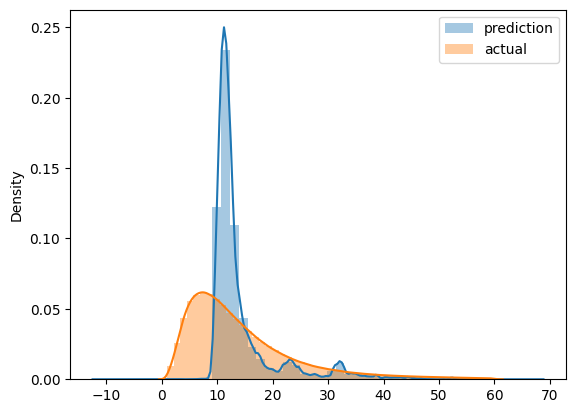

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe(f'{data_path}yellow_tripdata_2023-01.parquet')
df_val = read_dataframe(f'{data_path}yellow_tripdata_2023-02.parquet')

In [12]:
len(df_train), len(df_val)

(3009173, 2855951)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/Users/s.koc/.pyenv/versions/3.12.3/envs/mlops-zoomcamp/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.256227422749583

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
# lr = Lasso(0.01)
# lr.fit(X_train, y_train)
#
# y_pred = lr.predict(X_val)
#
# mean_squared_error(y_val, y_pred, squared=False)

In [19]:
with mlflow.start_run():

    mlflow.set_tag("DS", "Simge")

    mlflow.log_param("train-data-path", f'{data_path}yellow_tripdata_2023-01.parquet')
    mlflow.log_param("valid-data-path", f'{data_path}yellow_tripdata_2023-02.parquet')

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

/Users/s.koc/.pyenv/versions/3.12.3/envs/mlops-zoomcamp/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [21]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [22]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [23]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/s.koc/.pyenv/versions/3.12.3/envs/mlops-zoomcamp/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [18:26:16] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.25850                           
[1]	validation-rmse:8.55935                           
[2]	validation-rmse:7.95804                           
[3]	validation-rmse:7.44338                           
[4]	validation-rmse:7.00525                           
[5]	validation-rmse:6.63364                           
[6]	validation-rmse:6.32062                           
[7]	validation-rmse:6.05697                           
[8]	validation-rmse:5.83681                           
[9]	validation-rmse:5.65366                           
[10]	validation-rmse:5.50120                          
[11]	validation-rmse:5.37509                          
[12]	validation-rmse:5.27020                          
[13]	validation-rmse:5.18351                          
[14]	validation-rmse:5.11186                          
[15]	validation-rmse:5.05204                          
[16]	validation-rmse:5.00269                          
[17]	validation-rmse:4.96123                          
[18]	valid

KeyboardInterrupt: 

In [25]:
with mlflow.start_run():

    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/Users/s.koc/.pyenv/versions/3.12.3/envs/mlops-zoomcamp/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [18:33:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.37133
[1]	validation-rmse:8.75894
[2]	validation-rmse:8.22242
[3]	validation-rmse:7.75402
[4]	validation-rmse:7.34642
[5]	validation-rmse:6.99342
[6]	validation-rmse:6.68849
[7]	validation-rmse:6.42668
[8]	validation-rmse:6.20193
[9]	validation-rmse:6.01053
[10]	validation-rmse:5.84752
[11]	validation-rmse:5.70794
[12]	validation-rmse:5.59003
[13]	validation-rmse:5.48884
[14]	validation-rmse:5.40340
[15]	validation-rmse:5.33167
[16]	validation-rmse:5.27036
[17]	validation-rmse:5.21818
[18]	validation-rmse:5.17365
[19]	validation-rmse:5.13590
[20]	validation-rmse:5.10321
[21]	validation-rmse:5.07546
[22]	validation-rmse:5.05166
[23]	validation-rmse:5.03072
[24]	validation-rmse:5.01222
[25]	validation-rmse:4.99668
[26]	validation-rmse:4.98304
[27]	validation-rmse:4.97091
[28]	validation-rmse:4.96026
[29]	validation-rmse:4.95071
[30]	validation-rmse:4.94255
[31]	validation-rmse:4.93518
[32]	validation-rmse:4.92810
[33]	validation-rmse:4.92253
[34]	validation-rmse:4.9

/Users/s.koc/.pyenv/versions/3.12.3/envs/mlops-zoomcamp/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/s.koc/.pyenv/versions/3.12.3/envs/mlops-zoomcamp/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [18:50:28] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [24]:
mlflow.xgboost.autolog(disable=True)

In [26]:
with mlflow.start_run():

    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=50,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/Users/s.koc/.pyenv/versions/3.12.3/envs/mlops-zoomcamp/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [18:52:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.37133
[1]	validation-rmse:8.75894
[2]	validation-rmse:8.22242
[3]	validation-rmse:7.75402
[4]	validation-rmse:7.34642
[5]	validation-rmse:6.99342
[6]	validation-rmse:6.68849
[7]	validation-rmse:6.42668
[8]	validation-rmse:6.20193
[9]	validation-rmse:6.01053
[10]	validation-rmse:5.84752
[11]	validation-rmse:5.70794
[12]	validation-rmse:5.59003
[13]	validation-rmse:5.48884
[14]	validation-rmse:5.40340
[15]	validation-rmse:5.33167
[16]	validation-rmse:5.27036
[17]	validation-rmse:5.21818
[18]	validation-rmse:5.17365
[19]	validation-rmse:5.13590
[20]	validation-rmse:5.10321
[21]	validation-rmse:5.07546
[22]	validation-rmse:5.05166
[23]	validation-rmse:5.03072
[24]	validation-rmse:5.01222
[25]	validation-rmse:4.99668
[26]	validation-rmse:4.98304
[27]	validation-rmse:4.97091
[28]	validation-rmse:4.96026
[29]	validation-rmse:4.95071
[30]	validation-rmse:4.94255
[31]	validation-rmse:4.93518
[32]	validation-rmse:4.92810
[33]	validation-rmse:4.92253
[34]	validation-rmse:4.9

/Users/s.koc/.pyenv/versions/3.12.3/envs/mlops-zoomcamp/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/s.koc/.pyenv/versions/3.12.3/envs/mlops-zoomcamp/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [18:54:02] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [30]:
# logged_model = 'runs:2ac26805e5b34718a2d79422f19b1a9b/models_mlflow'

logged_model = 'mlruns/1/2ac26805e5b34718a2d79422f19b1a9b/artifacts/models_mlflow'
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model


/Users/s.koc/.pyenv/versions/3.12.3/envs/mlops-zoomcamp/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [18:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 2ac26805e5b34718a2d79422f19b1a9b

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
